# Лабораторная работа № 5

Соловьев Роман, М33001

Файл с парсом есть на гитхабе

Ссылка на полученный датасет: https://drive.google.com/drive/folders/1xwK7402-ZMI_Y_ppYg6ugBhyG6Vyvc9P?usp=drive_link

In [1]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from bpe import Encoder
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as tud
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sentence_transformers import SentenceTransformer

from config import PATH_TO_SAVE_CSV, VOCAB_SIZE, EPOCH_CNT

nltk.download('stopwords')

c:\Users\1\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Анализ и обработка текстов

In [2]:
df = pd.read_csv(PATH_TO_SAVE_CSV)
print(df.head(5))

   Page ind  Rating                                               Text
0         1     8.6  (This review has been originally published in ...
1         2     6.4  (This review has been originally published in ...
2         3     6.0  One day, while Tomomi was cross-dressing in th...
3         4     1.0  В игре нету Лесби, есть бисексуал, и нечего лю...
4         5     4.0  Pretty mediocre as you can't read more than fi...


In [3]:
def is_apostrophe(ch):
    return ch == '\''

def is_space(ch):
    return ch == ' '

def filter_check(ch):
    return is_space(ch) or is_apostrophe(ch) or ch.encode().isalpha()

def handle_text(s: str):
    ind = 0
    
    # Убираю автоматически созданные комментарии о том, 
    # что ревью взято с другого сайта или содержит спойлеры
    if s[0] == '(': 
        ind = s.index(')') + 1
    elif s[0] == '[':
        ind = s.index(']') + 1
    tmp_ind = s[ind:]
    
    tmp = "".join(filter(filter_check, tmp_ind)).lower()
    if str.isspace(tmp):
        tmp = ""
    return tmp

In [4]:
df_redact = df.copy()
df_redact["Text"] = df_redact["Text"].map(lambda x: handle_text(x))
df_redact = df_redact[df_redact["Text"] != ""]
print(df_redact.head(5))

   Page ind  Rating                                               Text
0         1     8.6  when you go exploring the dark and seedy under...
1         2     6.4  a while ago an italian dude named vittorio mos...
2         3     6.0  one day while tomomi was crossdressing in the ...
4         5     4.0  pretty mediocre as you can't read more than fi...
5         7     5.4  well here is my first review of a pretty well ...


In [5]:
print(len(df))
print(len(df_redact))

6839
6818


In [6]:
def merge_texts(texts: list[str]) -> str:
    return ' '.join(texts)
    
unique_words = merge_texts(df_redact["Text"]).split(' ')
print(len(unique_words))
counts = Counter(merge_texts(df_redact["Text"]).split())
words = counts.most_common(20000)
words = [[word, freq] for word, freq in words]
print(words[:30])

2416514
[['the', 135510], ['and', 65102], ['a', 60568], ['to', 58605], ['of', 57067], ['is', 44643], ['i', 37144], ['it', 35434], ['in', 34690], ['that', 32282], ['this', 24611], ['but', 21523], ['with', 20677], ['for', 20362], ['you', 19792], ['as', 17268], ['was', 16204], ['game', 16005], ['are', 15419], ['not', 13598], ['on', 12231], ['be', 11512], ['like', 11421], ['have', 11058], ['her', 10913], ['route', 10323], ['all', 10312], ['just', 10192], ['story', 9976], ['so', 9647]]


In [7]:
stop_words = stopwords.words('english')
print(stop_words)

def drop_stop_words(text: str):
    tmp = ""
    for w in text.split():
        if w not in stop_words:
            tmp += w
            tmp += " "

    return tmp

df_wo_sw = df_redact.copy()
df_wo_sw["Text"] = df_wo_sw["Text"].map(lambda x: drop_stop_words(x))
print(df_wo_sw.head(5))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
unique_words_wo_sw = merge_texts(df_wo_sw["Text"]).split(' ')
print(len(unique_words_wo_sw))
counts_wo_sw = Counter(merge_texts(df_wo_sw["Text"]).split())
words_wo_sw = counts_wo_sw.most_common(20000)
words_wo_sw = [[word, freq] for word, freq in words_wo_sw]
print(words_wo_sw[:30])

1226163
[['game', 16005], ['like', 11421], ['route', 10323], ['story', 9976], ['one', 9510], ['really', 8175], ['good', 7619], ['characters', 7206], ['even', 6700], ['also', 6464], ['much', 5937], ['character', 5915], ['time', 5569], ['get', 5144], ['vn', 4921], ['would', 4919], ['well', 4900], ['first', 4775], ['routes', 4111], ['pretty', 3916], ['way', 3855], ['end', 3741], ['plot', 3701], ['main', 3665], ['scenes', 3659], ['still', 3583], ['lot', 3569], ['think', 3504], ['feel', 3342], ['great', 3278]]


In [9]:
encoder = Encoder(VOCAB_SIZE, pct_bpe=0.2)
encoder.fit(df_wo_sw["Text"])

df_token = df_wo_sw.copy()
df_token = df_token.drop("Page ind", axis=1)

df_token["Text"] = df_token["Text"].map(lambda x: next(encoder.transform([x])))
print(df_token.head(5))

   Rating                                               Text
0     8.6  [61, 1602, 451, 1638, 1682, 1668, 1657, 1639, ...
1     6.4  [819, 1638, 1188, 1679, 1766, 1644, 1639, 1532...
2     6.0  [8, 256, 1638, 1723, 1756, 1710, 1639, 1638, 1...
4     4.0  [24, 958, 122, 2, 111, 37, 1180, 555, 89, 797,...
5     5.4  [20, 22, 153, 24, 20, 793, 39, 44, 1136, 1136,...


### Нейронная сеть

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
model_precalculated = SentenceTransformer('bert-base-nli-mean-tokens')

In [12]:
pd.options.mode.chained_assignment = None
df_embedded = df_wo_sw.copy()
for i in tqdm(range(len(df_embedded["Text"]))):
    df_embedded["Text"].iloc[i] = model_precalculated.encode(df_embedded["Text"].iloc[i])
print(df_embedded.head(5))

100%|██████████| 6818/6818 [13:40<00:00,  8.31it/s]

   Page ind  Rating                                               Text
0         1     8.6  [-0.37860528, 0.77255696, 0.8299056, 0.0932722...
1         2     6.4  [-0.37374157, 0.43657348, 0.5669644, 0.0006322...
2         3     6.0  [-0.4678542, 0.52570003, 0.68968654, 0.2353818...
4         5     4.0  [-0.29741347, 0.6932841, 0.1106248, 0.18829021...
5         7     5.4  [-0.5153186, 0.11187155, 0.58729756, 0.0945712...


In [13]:
print(len(df_embedded["Text"].iloc[0]))

768


In [14]:
df_embedded["Rating"] = df_embedded["Rating"].map(lambda x: ((float)(round(((x * 2)))) / 2.))
print(df_embedded.head(5))

   Page ind  Rating                                               Text
0         1     8.5  [-0.37860528, 0.77255696, 0.8299056, 0.0932722...
1         2     6.5  [-0.37374157, 0.43657348, 0.5669644, 0.0006322...
2         3     6.0  [-0.4678542, 0.52570003, 0.68968654, 0.2353818...
4         5     4.0  [-0.29741347, 0.6932841, 0.1106248, 0.18829021...
5         7     5.5  [-0.5153186, 0.11187155, 0.58729756, 0.0945712...


In [15]:
class LSTMCellWithLinear(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(LSTMCellWithLinear, self).__init__()

        self.seq = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, 2 * hidden_size),
            nn.Dropout(p=0.2),
            nn.Linear(2 * hidden_size, hidden_size),
            nn.Sigmoid(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        ).to(device)


    def forward(self, inputed): 
        x = self.seq(inputed)
        # пусть значения в датасете дискретные (ограничиваются одним знаком после запятой),
        # возвращать из модели буду предсказание регрессии в диапазоне от 1 до 10
        # это позволит менять степень уверенности модели
        x = torch.mul(x, 9)
        x = torch.add(x, 1)
        return x

In [16]:
def create_loaders(batch_size):
    train_x, test_x, train_y, test_y = train_test_split(df_embedded["Text"].to_list(), df_embedded["Rating"].to_list(), stratify=df_embedded["Rating"].to_list(), test_size=0.2, random_state=42)

    test_x_tensor = [torch.tensor(x, dtype=torch.float32, requires_grad=False) for x in test_x]
    train_x_tensor = [torch.tensor(x, dtype=torch.float32, requires_grad=False) for x in train_x]
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32, requires_grad=False)
    train_y_tensor = torch.tensor(train_y, dtype=torch.float32, requires_grad=False)

    test_x_tensor = nn.utils.rnn.pad_sequence(test_x_tensor, batch_first=True)
    train_x_tensor = nn.utils.rnn.pad_sequence(train_x_tensor, batch_first=True)

    train_data = tud.TensorDataset(train_x_tensor, train_y_tensor)
    test_data = tud.TensorDataset(test_x_tensor, test_y_tensor)
    
    return tud.DataLoader(train_data, batch_size=batch_size), tud.DataLoader(test_data, batch_size=batch_size), len(train_x), len(test_x)

def output_results(train_history, test_history, str):

    fig1 = plt.figure()
    plt.plot(train_history)
    plt.plot(test_history)
    plt.grid(True)
    plt.title('Сходимость')
    plt.xlabel('Эпоха')
    plt.ylabel(str)
    plt.legend(['train', 'test'])
    
    fig2 = plt.figure()
    plt.plot(train_history[5:])
    plt.plot(test_history[5:])
    plt.grid(True)
    plt.title('Сходимость после 5 эпохи')
    plt.xlabel('Эпоха')
    plt.ylabel(str)
    plt.legend(['train', 'test'])

    fig3 = plt.figure()
    plt.plot(train_history[500:])
    plt.plot(test_history[500:])
    plt.grid(True)
    plt.title('Сходимость после 500 эпохи')
    plt.xlabel('Эпоха')
    plt.ylabel(str)
    plt.legend(['train', 'test'])

    plt.show(fig1)
    plt.show(fig2)
    plt.show(fig3)

def train(model) -> nn.Module: 
        
    torch.manual_seed(42)
    criterion = nn.L1Loss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001)
    batch_size = 128

    train_loader, test_loader, n_train, n_test = create_loaders(batch_size)
    train_history, test_history = [], []
    
    for epoch in tqdm(range(EPOCH_CNT)):

        loss, mse, mae, mape = 0, 0, 0, 0

        for inputs, labels in train_loader:
            model.zero_grad()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss_now = criterion(outputs, labels.view(-1, 1))
            loss += loss_now.item()
            mse += mean_squared_error(outputs.detach().numpy(), labels.view(-1, 1).detach().numpy()) * len(inputs)
            mae += mean_absolute_error(outputs.detach().numpy(), labels.view(-1, 1).detach().numpy()) * len(inputs)
            mape += mean_absolute_percentage_error(outputs.detach().numpy(), labels.view(-1, 1).detach().numpy()) * len(inputs)
            loss_now.backward()
            optimizer.step()

        loss /= len(train_loader)
        mse /= n_train
        mae /= n_train
        mape /= n_train

        train_history.append([loss, mse, mae, mape])
        if epoch % 150 == 0:
            print(f'Epoch [{epoch+1}/{EPOCH_CNT}], Loss: {loss:.4f}')

        with torch.no_grad():
            loss, mse, mae, mape = 0, 0, 0, 0

            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss_now = criterion(outputs, labels.view(-1, 1))
                loss += loss_now.item()
                mse += mean_squared_error(outputs.detach().numpy(), labels.view(-1, 1).detach().numpy()) * len(inputs)
                mae += mean_absolute_error(outputs.detach().numpy(), labels.view(-1, 1).detach().numpy()) * len(inputs)
                mape += mean_absolute_percentage_error(outputs.detach().numpy(), labels.view(-1, 1).detach().numpy()) * len(inputs)

            loss /= len(test_loader)
            mse /= n_test
            mae /= n_test
            mape /= n_test

            test_history.append([loss, mse, mae, mape])

    inputs = [torch.tensor(x, dtype=torch.float32) for x in df_embedded["Text"]]
    inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    probs = model(inputs).max(dim=1).values.detach().numpy()

    score = mean_squared_error(df_embedded["Rating"], probs, squared=False)
    print(f'-----------------------------------')
    print(f'Root mean squared error {score:.3f}')

    train_history = list(zip(*train_history))
    test_history = list(zip(*test_history))

    output_results(train_history[0], test_history[0], "Loss")
    output_results(train_history[1], test_history[1], "MSE")
    output_results(train_history[2], test_history[2], "MAE")
    output_results(train_history[3], test_history[3], "MAPE")

    return model

def show_track(model):
    show = df_embedded.sample(40, random_state=13)
    x, y = show["Text"], show["Rating"]
    input_list = [torch.tensor(i, dtype=torch.float32, requires_grad=False) for i in x]
    inputs = nn.utils.rnn.pad_sequence(input_list, batch_first=True)
    outputs = model(inputs)
    print("Фактический рейтинг, предсказанный")
    y_out = y.to_string(index=False)
    y_out = y_out.split('\n')
    for i in range(len(y)):
        print("               " + y_out[i] + "   " + str(outputs.detach().numpy()[i][0]))


  0%|          | 1/1500 [00:00<20:42,  1.21it/s]

Epoch [1/1500], Loss: 1.7974


 10%|█         | 151/1500 [02:04<17:50,  1.26it/s]

Epoch [151/1500], Loss: 1.4103


 20%|██        | 301/1500 [04:12<17:16,  1.16it/s]

Epoch [301/1500], Loss: 1.3747


 30%|███       | 451/1500 [06:23<15:10,  1.15it/s]

Epoch [451/1500], Loss: 1.3567


 40%|████      | 601/1500 [08:30<12:27,  1.20it/s]

Epoch [601/1500], Loss: 1.3422


 50%|█████     | 751/1500 [10:38<10:25,  1.20it/s]

Epoch [751/1500], Loss: 1.3276


 60%|██████    | 901/1500 [12:47<08:42,  1.15it/s]

Epoch [901/1500], Loss: 1.3189


 70%|███████   | 1051/1500 [14:55<06:27,  1.16it/s]

Epoch [1051/1500], Loss: 1.3108


 80%|████████  | 1201/1500 [17:03<04:07,  1.21it/s]

Epoch [1201/1500], Loss: 1.3052


 90%|█████████ | 1351/1500 [19:11<02:04,  1.19it/s]

Epoch [1351/1500], Loss: 1.2989


100%|██████████| 1500/1500 [21:36<00:00,  1.16it/s]


-----------------------------------
Root mean squared error 1.726


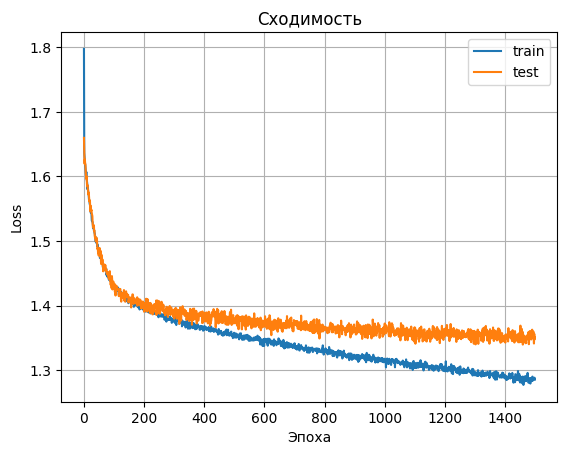

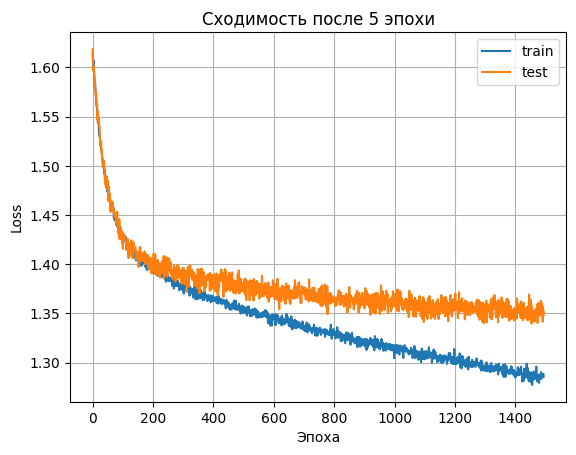

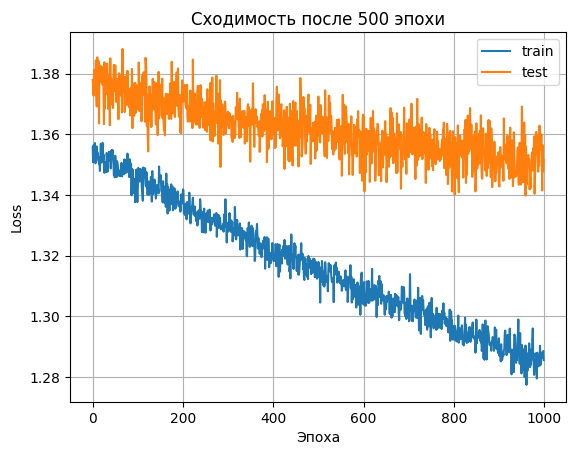

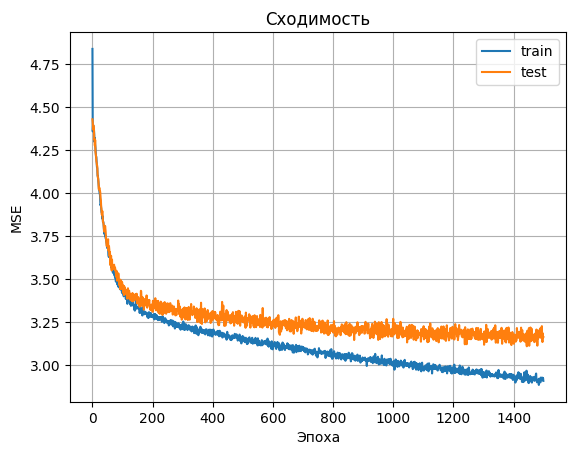

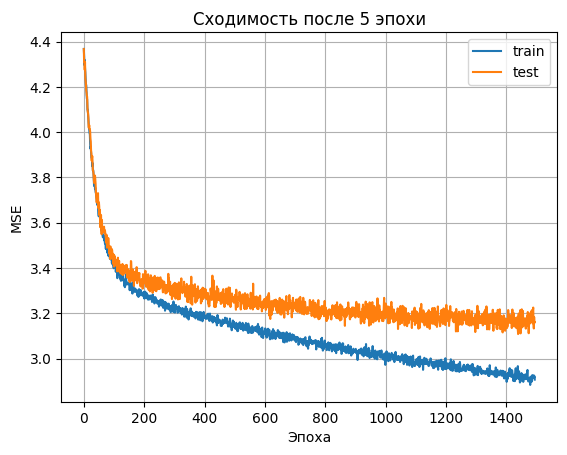

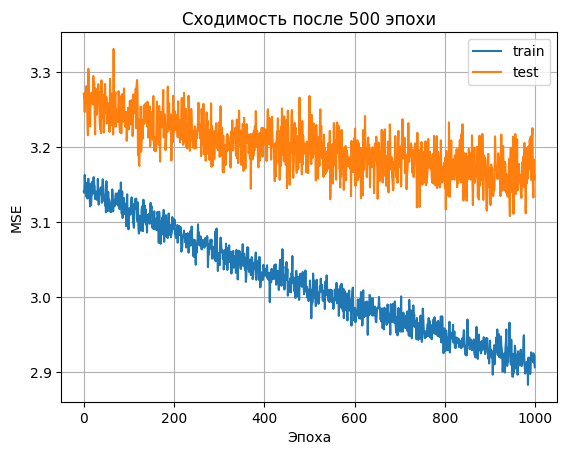

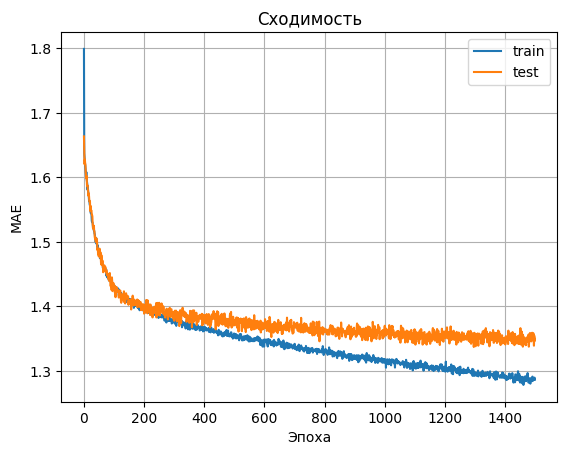

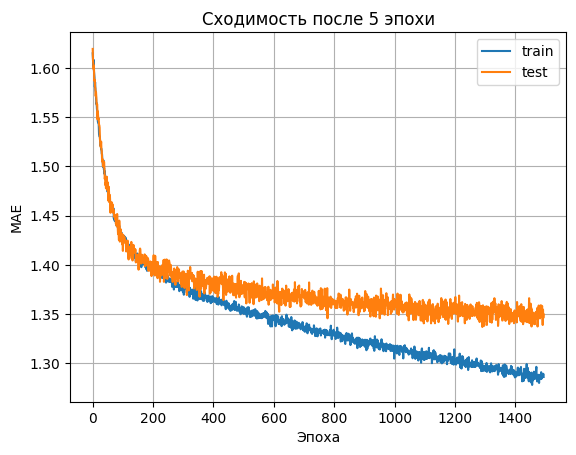

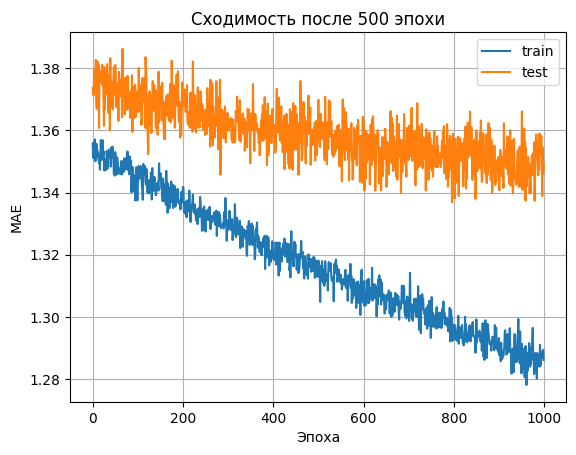

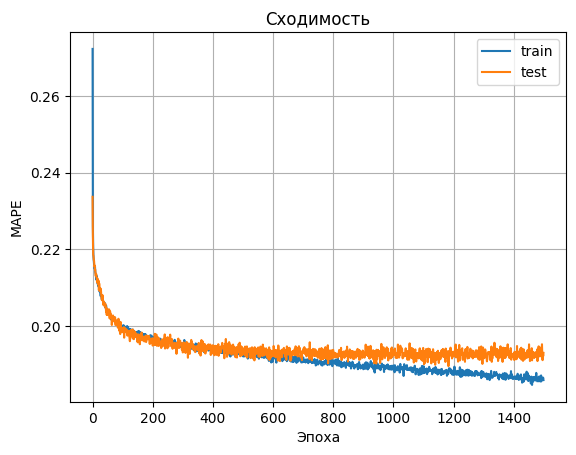

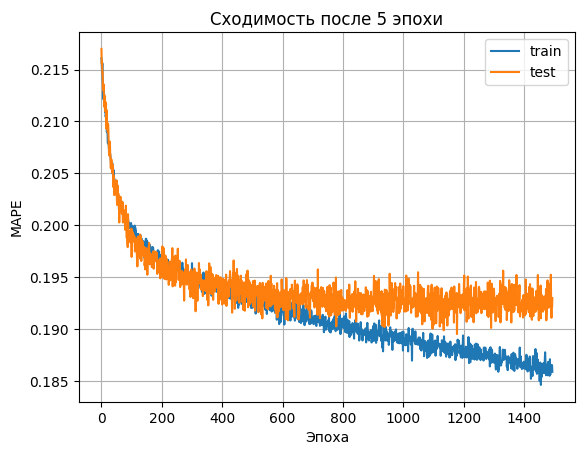

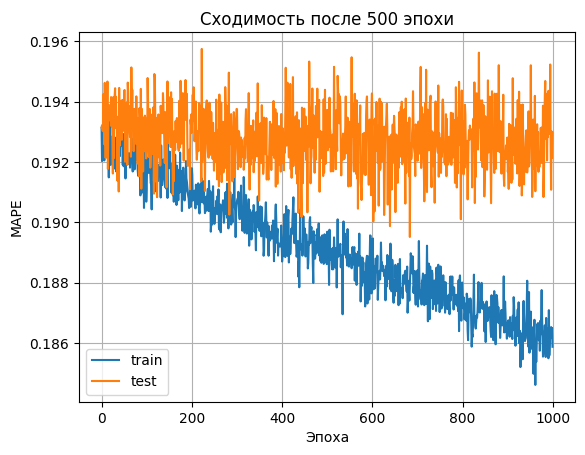

Фактический рейтинг, предсказанный
                7.5   6.111353
                7.0   7.535799
                7.0   6.1970277
                7.5   5.531662
                8.0   8.340258
                6.0   5.8383965
                6.0   8.404508
               10.0   9.685686
               10.0   8.015268
               10.0   8.885004
               10.0   7.3865767
                8.0   5.458668
                4.0   4.972719
                7.0   6.0505114
                9.5   9.182786
                8.5   7.5584607
                9.0   6.953511
                9.0   5.674982
                6.0   7.702328
                8.0   6.451088
                7.5   8.244067
                8.0   8.744254
               10.0   9.32515
                8.0   7.017894
                9.5   9.303109
               10.0   7.5516853
               10.0   7.7511554
                7.0   7.853588
                8.0   7.2160087
                8.0   6.775552
                9.0   6.5839

In [17]:
model = LSTMCellWithLinear(hidden_size=len(df_embedded["Text"].iloc[0]), output_size=1)

model = train(model)

show_track(model)

За исключением редких выбросов предсказанная оценка отличается меньше, чем на 2.

Выведя до этого результаты с 1000 эпохами была примерно такая же картина, но с чуть большими выбросами.

Тем самым обучение сглаживает выбросы, а ошибки меньше, чем на 2 исправляет хуже, так как сталкивается со следующей проблемой:

Предсказывать всегда точнее тяжело, потому что у людей разное восприятие ранжирования
(Разные люди при одинаковом впечатлении поставят разную оценку из-за разного 
восприятия (например, что достойно 9, а что 8))